VAD - voice activity detection


imoprt packages

In [2]:

import os
import numpy as np
import librosa
import librosa.display
import math, random
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import torchaudio
from torchaudio import transforms
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.utils import Sequence
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import MaxPooling2D, Conv2D
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import pandas as pd
from pathlib import Path
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')    
import datetime
from tensorflow.keras.callbacks import TensorBoard



In this project, we tried to classify sounds into two categories: speech and noise (non-speech sounds). The data that were used as input: in the noise category - a recording of a quiet room, recordings from a window of a tall building in Manhattan, recordings of birds chirping, recordings of cars on a main road, air conditioner noises, car horns, children in a playground, dogs barking, a drill, gunshots, hammer bangs, Sirens and street music. all this kind of noises were downloaded from the internet. Some from Youtube and some from the urbansound8k website, URL: https://urbansounddataset.weebly.com/urbansound8k.html
In the speech category - we downloaded podcasts and conversation recordings from the internet.
The recordings were saved as segments of several seconds. Half of the files are noise and half are speech i.e. proximity 8 hours of noises and 8 hours of speech. The data are randomly divided into 70% training, 20% validation, and 10% testing. In the next cell, the data are loaded and split into those groups: train, validation, and test. we created another set of noises, to merge noise and voice segments with different SNRs.

In [3]:
# ----------------------------
# we load the SCV file that contain the path and the labels of each file
# ----------------------------

metadata_file_voice = r'C:\Users\User\Downloads\few_spekers\voice_metadata.csv'
metadata_file_noise = r'C:\Users\User\Downloads\few_spekers\noise_metadata.csv'
df_voice = pd.read_csv(metadata_file_voice) 
df_noise = pd.read_csv(metadata_file_noise) 


# ----------------------------
# we devide the dataframe into train, val and test : 80%, 10%, 10%
# then rest the indexes
# ----------------------------
df_train_voice, df_val_voice, df_test_voice = np.split(df_voice.sample(frac=1), [int(0.7*len(df_voice)), int(0.9*len(df_voice))])
df_train_voice = df_train_voice.reset_index()
df_test_voice = df_test_voice.reset_index()
df_val_voice = df_val_voice.reset_index()

df_train_noise, df_val_noise, df_test_noise = np.split(df_noise.sample(frac=1), [int(0.7*len(df_noise)), int(0.9*len(df_noise))])
df_train_noise = df_train_noise.reset_index()
df_test_noise = df_test_noise.reset_index()
df_val_noise = df_val_noise.reset_index()

# ----------------------------
# the path of the all files
# ----------------------------
data_path = r'C:\Users\User\Downloads\few_spekers\wav files'

#-----------------------------
# Another set of train
# The model is merging between voice and noise and create a "dirty voice"
# in order to train the model with different set of noise that not necessarily the same as the noise in the "dirty voice"
# we create another set
#-----------------------------
df_train_noise_2, df_val_noise_2, df_test_noise_2 = np.split(df_noise.sample(frac=1), [int(0.7*len(df_noise)), int(0.9*len(df_noise))])
df_train_noise_2 = df_train_noise_2.reset_index()
df_test_noise_2 = df_test_noise_2.reset_index()
df_val_noise_2 = df_val_noise_2.reset_index()


The data includes 13,903 files up to 4 seconds long of speech and noise. 70% in the training set, 20% in the validation set, and 10% in the test set. All the recordings were passed through a process that ends up with mel-spectrograms which are entered into the cnn.

In the next cell, we generated a Class named AudioUtil. In this class, each audio file is loaded, resampled, truncated, or padded with zeros to 1 second long and time-shifted, which is the first augmentation. Then Mel-spectrogram with 128 filters (default number), FFT numbers of 1024, and a hop length of 256 are created.

The next function is the SNR func. First, the function draws a random SNR value between -5 to 30. Then it takes two segments - voice and noise and fixed them according to the SNR value we got, then merges them into one segment, labeled as voice. Then masked in frequency and time - which is the second augmentation, and normalized between 0 to 1.

The mel-spectrograms were then fed into the neural network. 
The labels of the spectrogram are 1 for the voice and 0 for the noise.

In [4]:
# ----------------------------
# the class of the audio pre-proccesing 
# ----------------------------
class AudioUtil():
    
    # ----------------------------
    # Load an audio file. Return the signal as mono and the sample rate
    # ----------------------------

    def open_file(audio_file):
        
        sig, sr = librosa.load(audio_file, sr=None, mono=True)

        return (sig, sr)

    # ----------------------------
    # Resample the file to a desired sample rate
    # ----------------------------

    def resample(aud, newsr):
        
        sig, sr = aud

        if (sr == newsr):
            # Nothing to do
            return aud
        else:
            resig = librosa.resample(sig ,orig_sr=sr, target_sr=newsr)

            return (resig, newsr)

    # ----------------------------
    # Pad or truncate the signal to a fixed length 'max_ms' in milliseconds
    # ----------------------------

    def pad_trunc(aud, max_ms):

        sig, sr = aud
        sig_len = len(sig)
        max_len = sr//1000 * max_ms

        if (sig_len > max_len):
            # Truncate the signal to the given length
            sig = sig[:max_len]

        elif (sig_len < max_len):
            # Length of padding to add at the beginning and the end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            # Pad with 0s
            pad_begin = np.zeros( pad_begin_len)
            pad_end = np.zeros( pad_end_len)

            sig = np.concatenate((pad_begin, sig, pad_end))

        return (sig, sr)


    # ----------------------------
    # Shifts the signal to the left or right by some percent. Values at the end
    # are 'wrapped around' to the start of the transformed signal.
    # ----------------------------

    def time_shift(aud, shift_limit):

        sig ,sr = aud
        sig_len = len(sig)
        shift_amt = int(random.random() * shift_limit * sig_len)

        return (np.roll(sig, shift_amt), sr)
    
    #---------------------------
    
    #---------------------------
    
    def SNR(aud_voice, aud_noise):
        
        sig_voice ,sr_voice = aud_voice
        sig_noise ,sr_noise = aud_noise
        
        random_SNR = np.random.randint(-5,31, size=1)
        
        RMS_voice = 20*np.log10(librosa.feature.rms(sig_voice, frame_length=len(sig_voice), center=False))
        RMS_noise = 20*np.log10(librosa.feature.rms(sig_noise, frame_length=len(sig_noise), center=False))
        
        gain = (RMS_voice - RMS_noise) - random_SNR
        
        dB_to_dec = 10**(gain/20)

        if dB_to_dec <=1 :

            sig_noise = (sig_noise*dB_to_dec).astype('float32')

        else:
            sig_voice = (sig_voice/dB_to_dec).astype('float32')

        new_signal = sig_noise + sig_voice

        sig_voice = np.squeeze(new_signal)
        
        return (sig_voice, sr_voice)
    

    # ----------------------------
    # Generate a Spectrogram - we generate a mel spectrogram
    # ----------------------------
    def spectro_gram(aud, n_fft=None, hop_length=None):
        
        sig ,sr = aud
        
        spectogram = librosa.feature.melspectrogram(sig, sr=sr, n_fft=n_fft, hop_length=hop_length, center=False)

        # Convert to decibels
        spectogram_db = librosa.amplitude_to_db(np.abs(spectogram), ref=np.max)

        return spectogram_db
    
    # ---------------------------
    # Augment the Spectrogram by masking out some sections of it in both the frequency
    # dimension and the time dimension (vertical bars) to prevent
    # overfitting and to help the model generalise better. The masked sections are
    # replaced with the mean value.
    # ----------------------------

    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):

        n_mels, n_steps = spec.shape
        
        spec = torch.from_numpy(spec)
        
        spec = spec.reshape(1, n_mels, n_steps)

        mask_value = spec.mean()
        
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels

        for i in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

        time_mask_param = max_mask_pct * n_steps

        for i in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

        aug_spec = aug_spec.numpy()
        aug_spec = aug_spec.reshape(n_mels, n_steps)

        return aug_spec

    # ----------------------------
    # we normalize the values between 0 to 1 
    # ----------------------------
    def normalized_spec(spec):

        #scaler = MinMaxScaler(feature_range=(-1,1))
        scaler = MinMaxScaler()
        normalized_spec = scaler.fit_transform(spec)

        return normalized_spec
    

In the next cell, we generated Class named DataGenerator .The calss inherited from tensorflow.keras.utils.Sequence. This class defines a set of initial parameters like sample rate, audio file duration, percentage of time-shifting, path of files, batch size, and the data itself.

In [5]:
# ----------------------------
# the class that generate the DataGenerator to the nerual network model
# ----------------------------
class DataGenerator(Sequence):


    def __init__(self, df_train_voice, df_val_voice, df_train_noise, df_train_noise_2, df_val_noise, df_val_noise_2, data_path, batch_size, flag=0):
        self.df_train_voice = df_train_voice
        self.df_val_voice = df_val_voice
        self.df_train_noise = df_train_noise
        self.df_train_noise_2 = df_train_noise_2
        self.df_val_noise = df_val_noise
        self.df_val_noise_2 = df_val_noise_2
        self.data_path = str(data_path)
        self.batch_size = batch_size
        self.duration = 1000   # we set the length of the files to 4 s
        self.sr = 16000   # we set the sample rate of the files to 16000 Hz
        self.shift_pct = 0.1   # we set the shifting rate of the files to 0.3
        self.flag = flag   # determen if display the spectrograms or not - 1 = show the spectrograms, 0 = does not show
        

    # ----------------------------
    # Number of items in dataset
    # ----------------------------
    def __len__(self):
        
        min_df_train = min(len(self.df_train_voice), len(self.df_train_noise)) 
        return min_df_train // self.batch_size


    # ----------------------------
    # Get i'th item in dataset
    # ----------------------------
    
    def __getitem__(self, idx):

        batch = range((idx * self.batch_size) , ((idx + 1) * self.batch_size)) 
        
        X, y = self.__get_data(batch)
        
        return X, y
    

    def __get_data(self, batch):
            
        X_train = []
        y_train = []
        
        for i in batch:

            audio_file_voice = self.data_path + self.df_train_voice.loc[i, 'path'][45:] # taking the path
            
            class_id_voice = self.df_train_voice.loc[i, 'class'] # Get the Class ID
            
            
            audio_file_noise_for_merge = self.data_path + self.df_train_noise_2.loc[i, 'path'][45:] # taking the path
            
            class_id_noise_for_merge = self.df_train_noise_2.loc[i, 'class'] # Get the Class ID
            
            
            aud_voice = AudioUtil.open_file(audio_file_voice) # load the file
            
            aud_noise_for_merge = AudioUtil.open_file(audio_file_noise_for_merge) # load the file
            
            
            reaud_voice = AudioUtil.resample(aud_voice, self.sr) # resample it to the desired SR
            
            reaud_noise_for_merge = AudioUtil.resample(aud_noise_for_merge, self.sr) # resample it to the desired SR
            
            
            dur_aud_voice = AudioUtil.pad_trunc(reaud_voice, self.duration) # padding or truncating the signal
            
            dur_aud_noise_for_merge = AudioUtil.pad_trunc(reaud_noise_for_merge, self.duration) # padding or truncating the signal
            
            
            shift_aud_voice = AudioUtil.time_shift(dur_aud_voice, self.shift_pct) # shifting the signal
            
            shift_aud_noise_for_merge = AudioUtil.time_shift(dur_aud_noise_for_merge, self.shift_pct) # shifting the signal
            
            
            voice_noise_signal = AudioUtil.SNR(shift_aud_voice,shift_aud_noise_for_merge)
            
            
            
            # the next section refer to the noise only
            
            audio_file_noise = self.data_path + self.df_train_noise.loc[i, 'path'][45:] # taking the path
            
            class_id_noise = self.df_train_noise.loc[i, 'class'] # Get the Class ID
            
            aud_noise = AudioUtil.open_file(audio_file_noise) # load the file
            
            reaud_noise = AudioUtil.resample(aud_noise, self.sr) # resample it to the desired SR
            
            dur_aud_noise = AudioUtil.pad_trunc(reaud_noise, self.duration) # padding or truncating the signal
            
            shift_aud_noise = AudioUtil.time_shift(dur_aud_noise, self.shift_pct) # shifting the signal
            
            
            # creating the spectrograms of the "dirty voice" and the noise
            
            
            sgram_voice = AudioUtil.spectro_gram(voice_noise_signal, n_fft=1024, hop_length=256) # create spectrogram with n_fft=1024, hop_length=256 and n_mels=128(defult number)
            
            sgram_noise = AudioUtil.spectro_gram(shift_aud_noise, n_fft=1024, hop_length=256) # create spectrogram with n_fft=1024, hop_length=256 and n_mels=128(defult number)
            
            
            aug_sgram_voice = AudioUtil.spectro_augment(sgram_voice, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1) # creat augmentation by frequncy and time masking 
            
            aug_sgram_noise = AudioUtil.spectro_augment(sgram_noise, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1) # creat augmentation by frequncy and time masking 
            
            
            norm_spec_voice = AudioUtil.normalized_spec(aug_sgram_voice) # normelazie between 0 to 1
            
            norm_spec_noise = AudioUtil.normalized_spec(aug_sgram_noise) # normelazie between 0 to 1
            
            
            X_train.append(norm_spec_voice)
            y_train.append(class_id_voice)
            
            X_train.append(norm_spec_noise)
            y_train.append(class_id_noise)


        X_train = np.array(X_train)
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
        y_train = np.array(y_train)
        y_train = np_utils.to_categorical(y_train)

        return (X_train, y_train)
            
        
    def load_val(self):
        
        X_val = []
        y_val = []
        min_df_val = min(len(self.df_val_voice), len(self.df_val_noise))
        
        for j in range(min_df_val):
            
            audio_file_voice = self.data_path + self.df_val_voice.loc[j, 'path'][45:] # taking the path
            
            class_id_voice = self.df_val_voice.loc[j, 'class'] # Get the Class ID
            
            
            audio_file_noise_for_merge = self.data_path + self.df_val_noise_2.loc[j, 'path'][45:] # taking the path
            
            class_id_noise_for_merge = self.df_val_noise_2.loc[j, 'class'] # Get the Class ID
            
            
            aud_voice = AudioUtil.open_file(audio_file_voice) # load the file
            
            aud_noise_for_merge = AudioUtil.open_file(audio_file_noise_for_merge) # load the file
            
            reaud_voice = AudioUtil.resample(aud_voice, self.sr) # resample it to the desired SR
            
            reaud_noise_for_merge = AudioUtil.resample(aud_noise_for_merge, self.sr) # resample it to the desired SR
            
            
            dur_aud_voice = AudioUtil.pad_trunc(reaud_voice, self.duration) # padding or truncating the signal
            
            dur_aud_noise_for_merge = AudioUtil.pad_trunc(reaud_noise_for_merge, self.duration) # padding or truncating the signal
            
            
            shift_aud_voice = AudioUtil.time_shift(dur_aud_voice, self.shift_pct) # shifting the signal
            
            shift_aud_noise_for_merge = AudioUtil.time_shift(dur_aud_noise_for_merge, self.shift_pct) # shifting the signal
            
            
            voice_noise_signal = AudioUtil.SNR(shift_aud_voice,shift_aud_noise_for_merge)
            
            
            
            # the next section refer to the noise only
            
            audio_file_noise = self.data_path + self.df_val_noise.loc[j, 'path'][45:] # taking the path
            
            class_id_noise = self.df_val_noise.loc[j, 'class'] # Get the Class ID
            
            aud_noise = AudioUtil.open_file(audio_file_noise) # load the file
            
            reaud_noise = AudioUtil.resample(aud_noise, self.sr) # resample it to the desired SR
            
            dur_aud_noise = AudioUtil.pad_trunc(reaud_noise, self.duration) # padding or truncating the signal
            
            shift_aud_noise = AudioUtil.time_shift(dur_aud_noise, self.shift_pct) # shifting the signal
            
            
            # creating the spectrograms of the "dirty voice" and the noise
            

            sgram_voice_noise = AudioUtil.spectro_gram(voice_noise_signal, n_fft=1024, hop_length=256) # create spectrogram with n_fft=1024, hop_length=256 and n_mels=128(defult number)
            
            sgram_noise = AudioUtil.spectro_gram(shift_aud_noise, n_fft=1024, hop_length=256) # create spectrogram with n_fft=1024, hop_length=256 and n_mels=128(defult number)
            
            
            sgram_voice = AudioUtil.spectro_gram(shift_aud_voice, n_fft=1024, hop_length=256) # create spectrogram with n_fft=1024, hop_length=256 and n_mels=128(defult number)
            
            
            aug_sgram_voice_noise = AudioUtil.spectro_augment(sgram_voice_noise, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1) # creat augmentation by frequncy and time masking 
            
            aug_sgram_noise = AudioUtil.spectro_augment(sgram_noise, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1) # creat augmentation by frequncy and time masking 
            
            
            aug_sgram_voice = AudioUtil.spectro_augment(sgram_voice, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1) # creat augmentation by frequncy and time masking 
            
            
            norm_spec_voice_noise = AudioUtil.normalized_spec(aug_sgram_voice_noise) # normelazie between 0 to 1
            
            norm_spec_noise = AudioUtil.normalized_spec(aug_sgram_noise) # normelazie between 0 to 1
            
            
            X_val.append(norm_spec_voice_noise)
            y_val.append(class_id_voice)
            
            X_val.append(norm_spec_noise)
            y_val.append(class_id_noise)
            
            # ----------------------------
            # displaying the mel-spectrograms of the val data set
            # in order to display a limited amount of spectrograms we add a constraint
            # ----------------------------
            
            if self.flag == 1:
                if (j/30).is_integer():
                    
                    fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)
                    img_0 = librosa.display.specshow(aug_sgram_voice_noise, sr=self.sr, x_axis='time', y_axis='linear', ax=ax[0] ,hop_length=256)
                    ax[0].set(title='spectrogram of voice and noise, class: ' + str(class_id_voice))
                    
                    img_1 = librosa.display.specshow(aug_sgram_noise, sr=self.sr, x_axis='time', y_axis='linear', ax=ax[1] ,hop_length=256)
                    ax[1].set(title='spectrogram of noise, class: ' + str(class_id_noise))
                    
                    img_2 = librosa.display.specshow(aug_sgram_voice, sr=self.sr, x_axis='time', y_axis='linear', ax=ax[2] ,hop_length=256)
                    ax[2].set(title='spectrogram of voice, class: ' + str(class_id_voice))
                    
                    plt.colorbar(img_0, ax=[ax[0]])
                    plt.colorbar(img_1, ax=[ax[1]])
                    plt.colorbar(img_2, ax=[ax[2]])
            
            # ----------------------------
            # displaying the audio segments of the merging segments (voice and noise) of the val data set
            # in order to get a limited amount of audio segments we add a constraint
            # ----------------------------
            if (j/30).is_integer():
                    display(Audio(voice_noise_signal[0], rate=self.sr))

        X_val = np.array(X_val)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
        y_val = np.array(y_val)
        y_val = np_utils.to_categorical(y_val)

        return (X_val, y_val)

We set a batch size of 50, and flag=1 in order to see the mel-spectrograms.

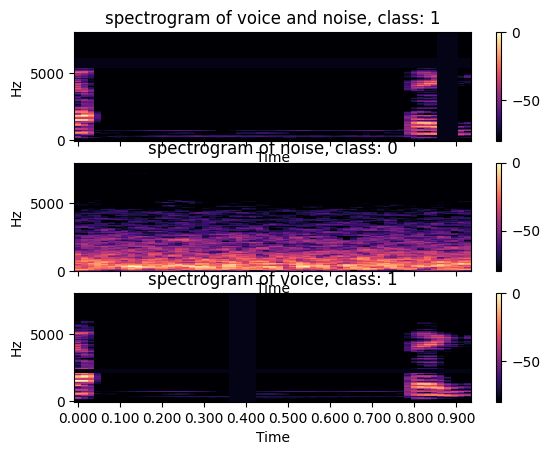

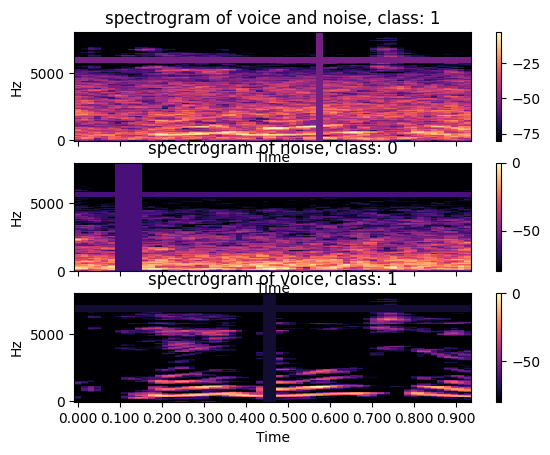

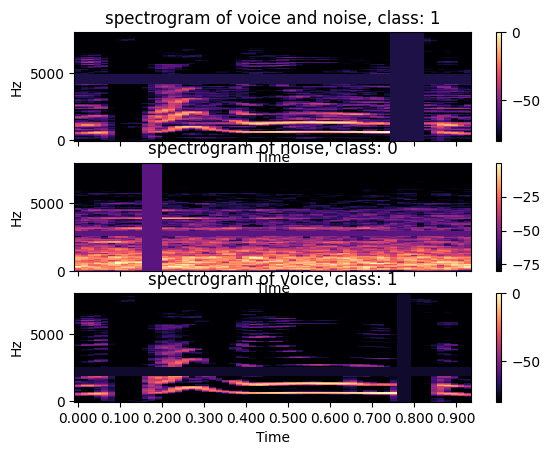

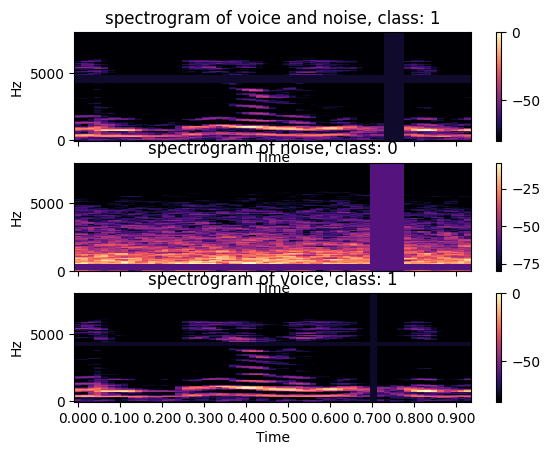

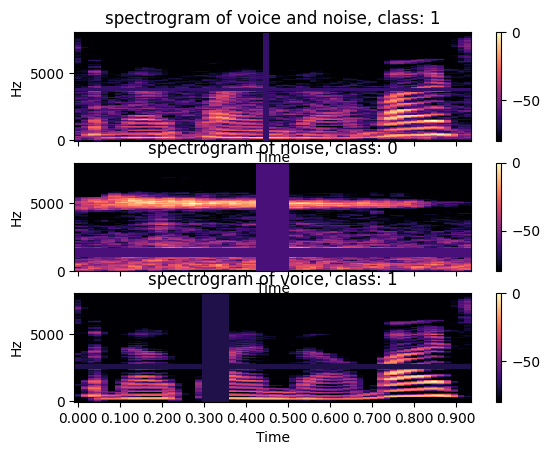

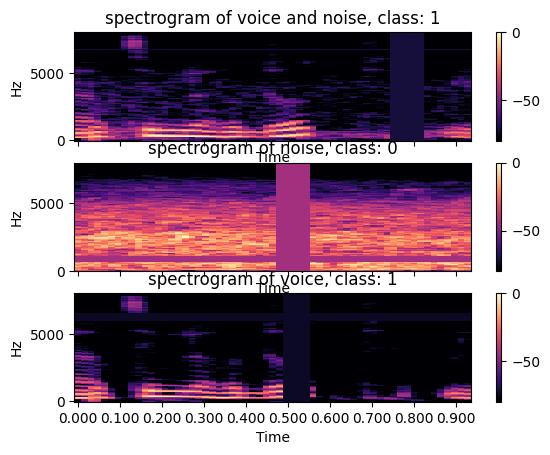

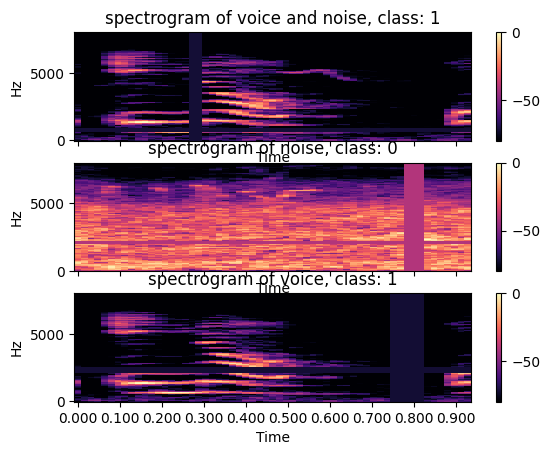

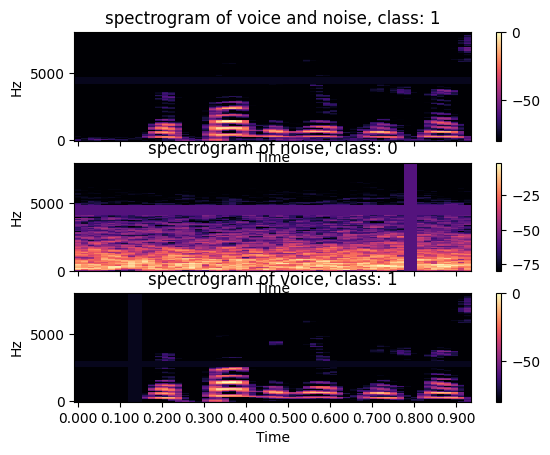

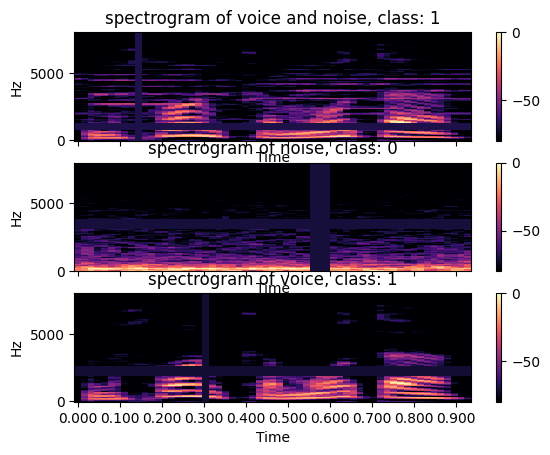

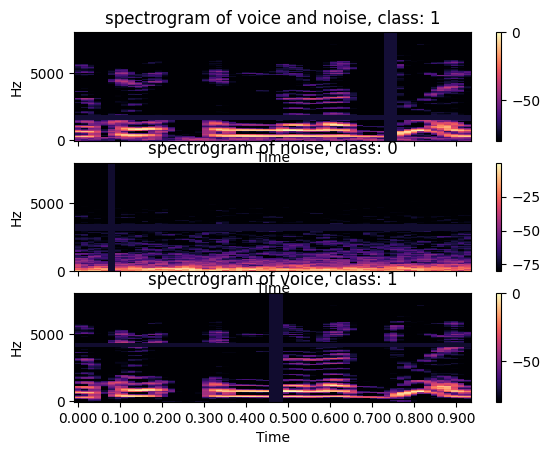

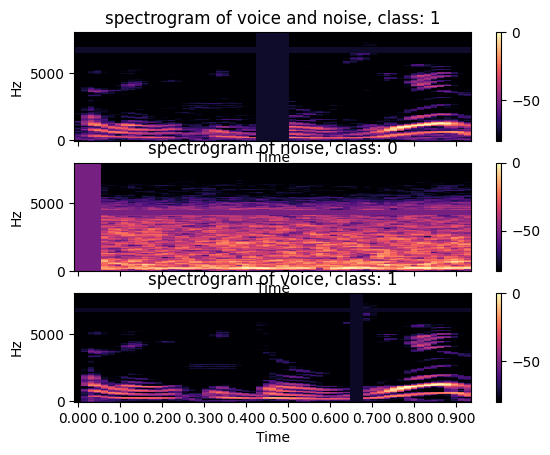

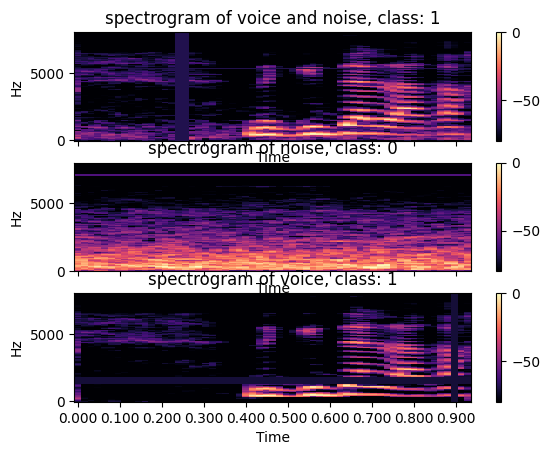

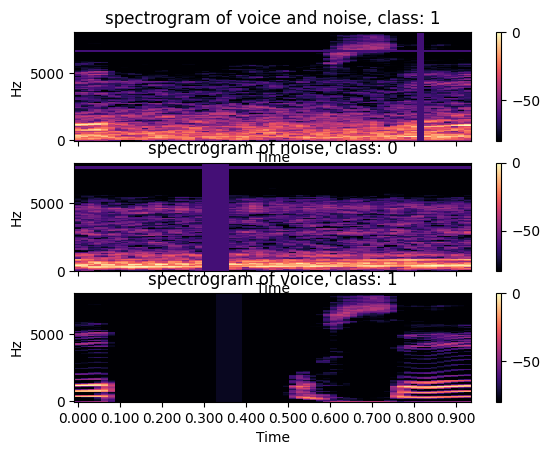

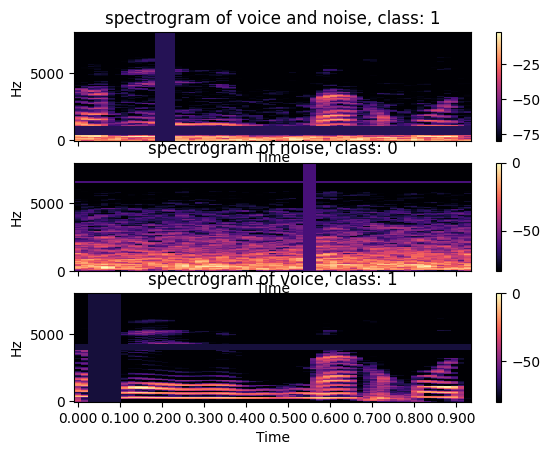

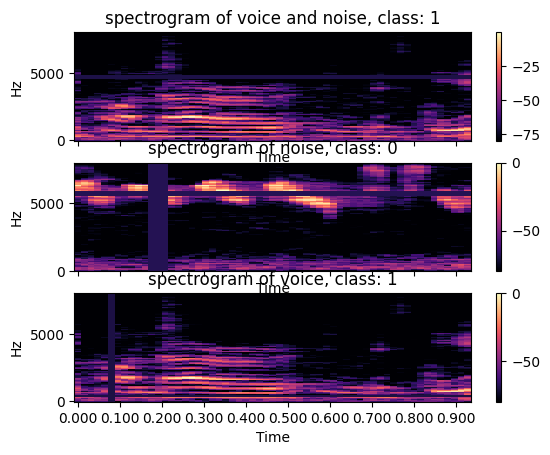

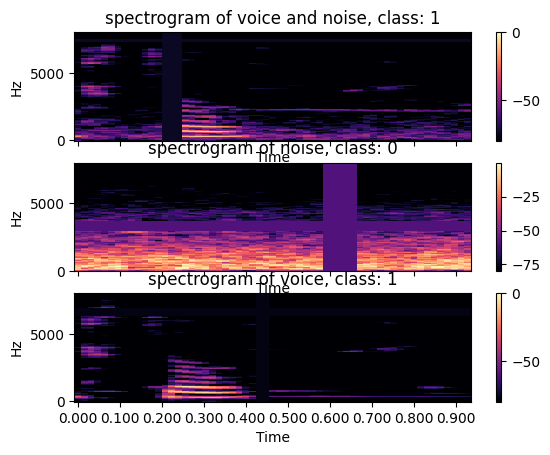

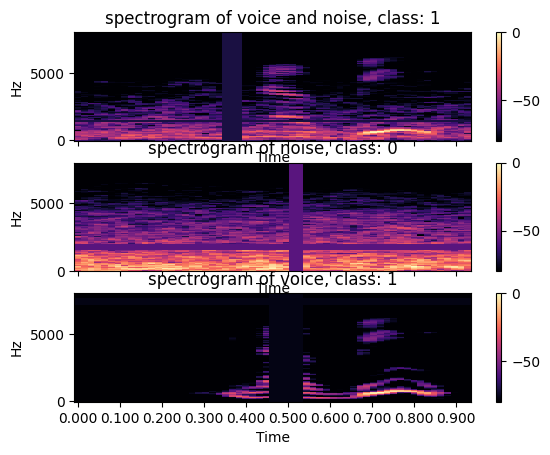

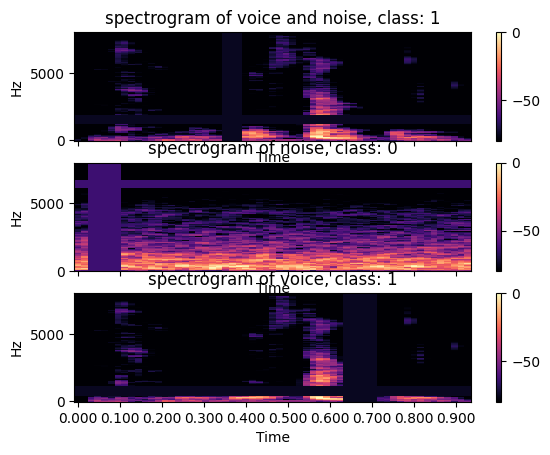

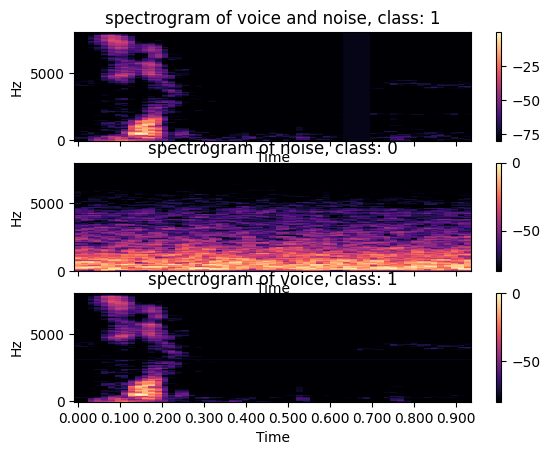

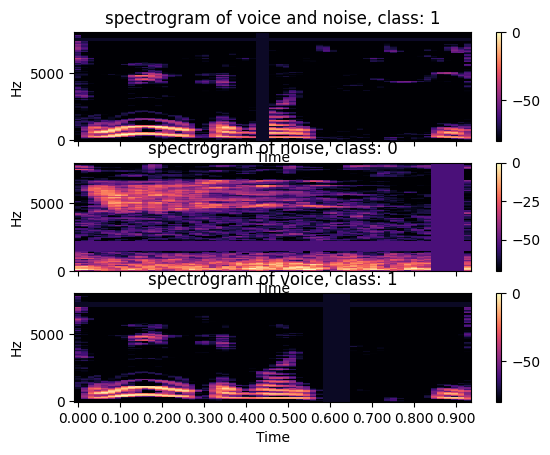

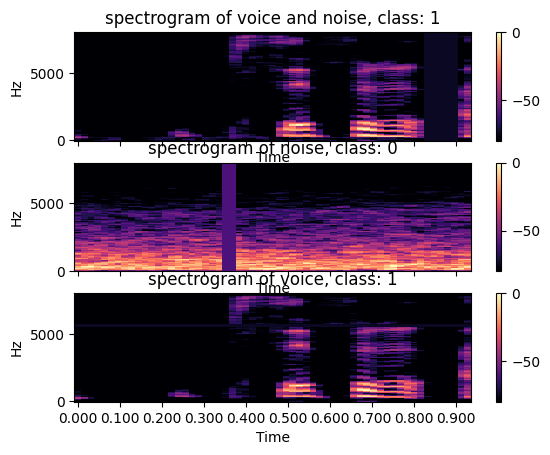

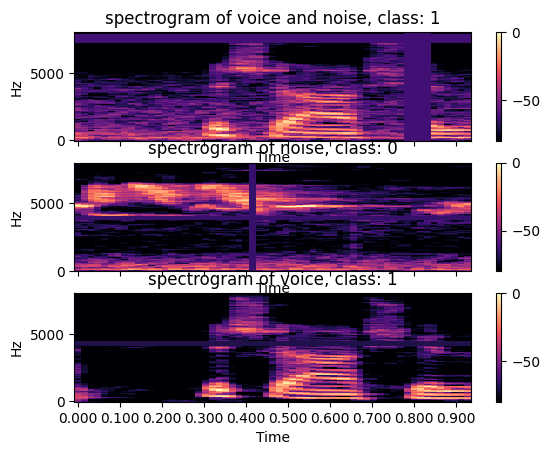

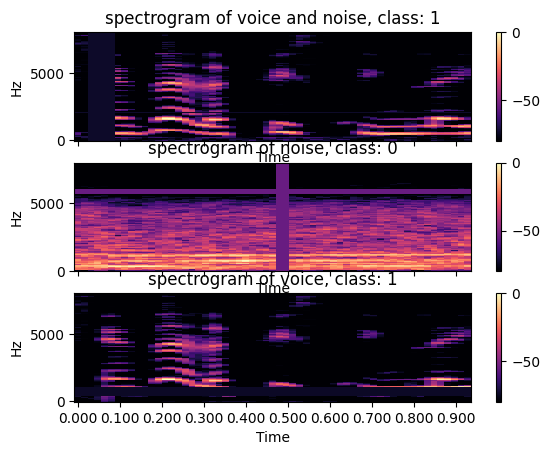

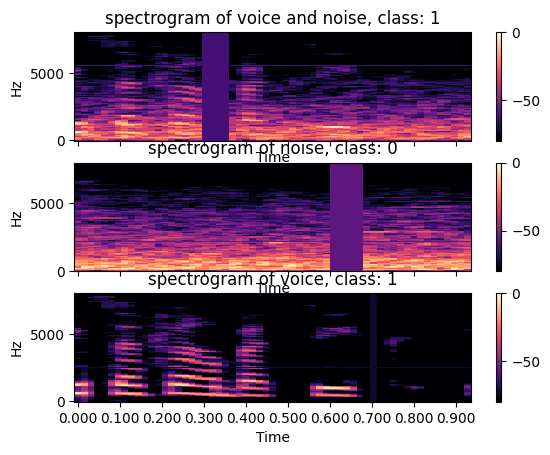

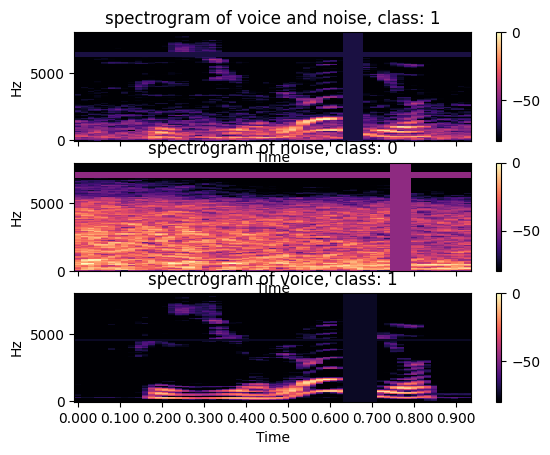

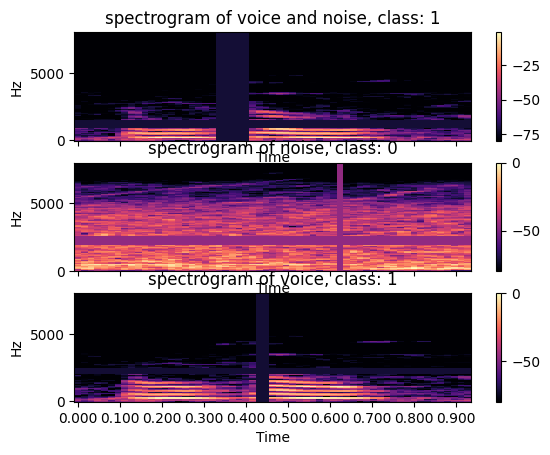

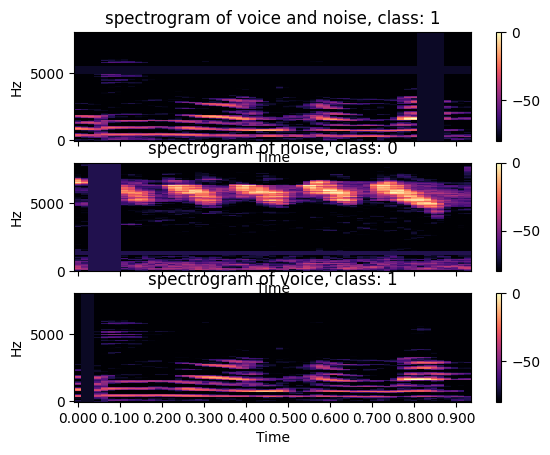

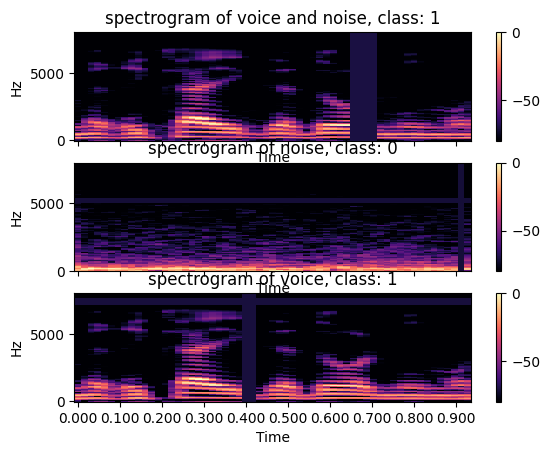

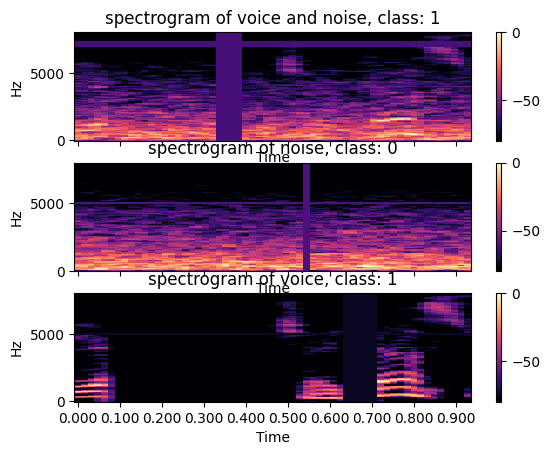

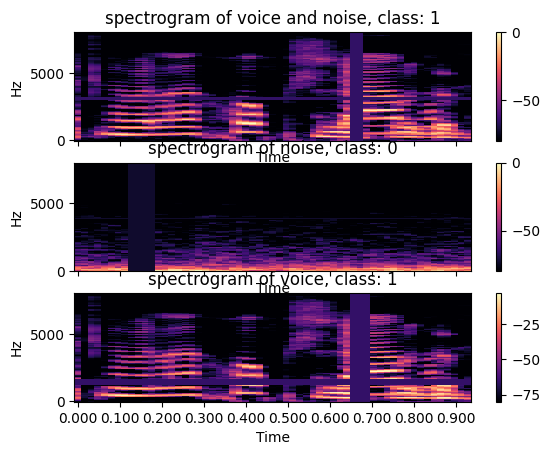

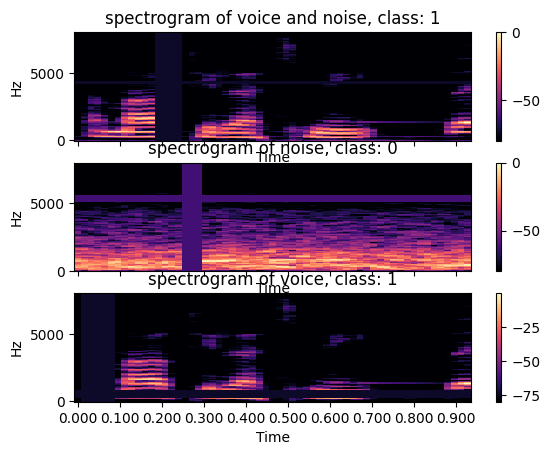

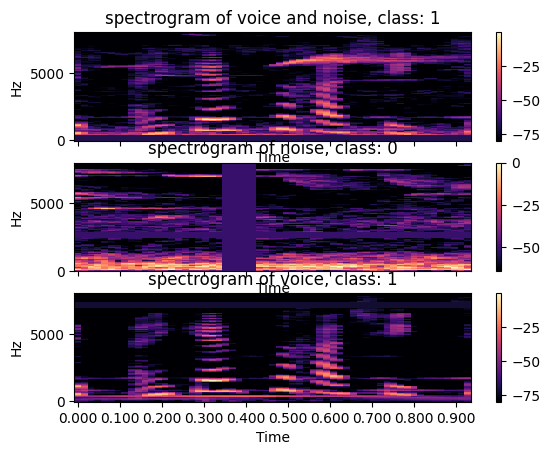

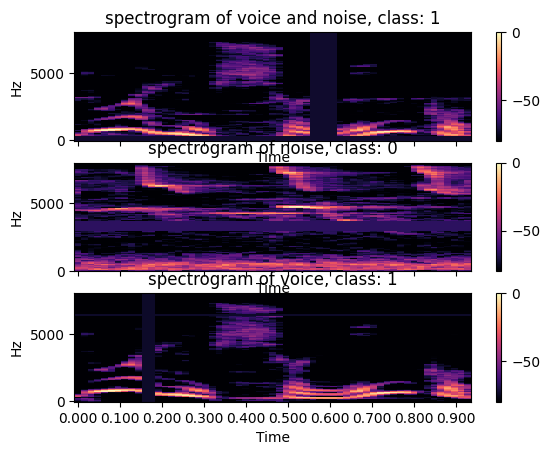

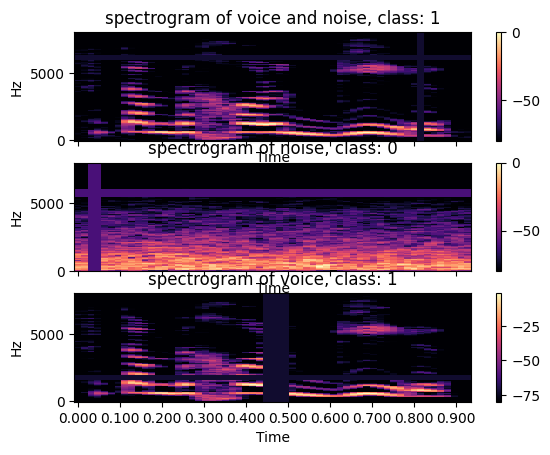

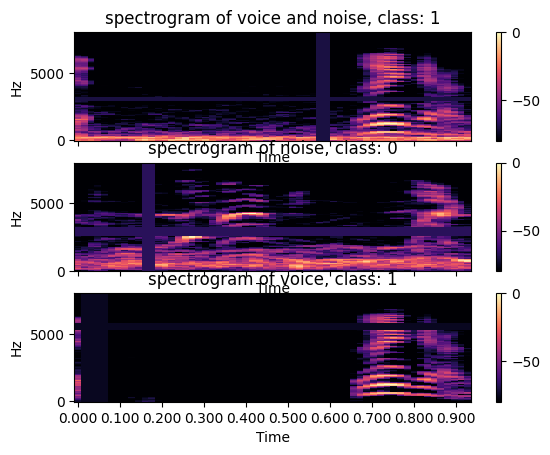

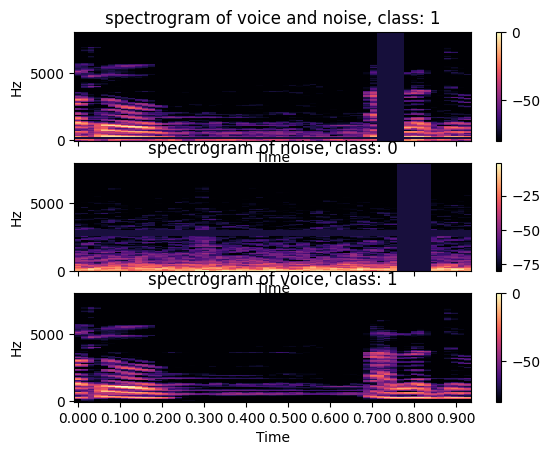

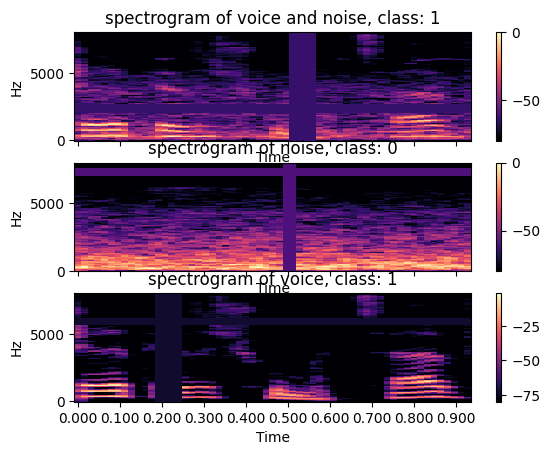

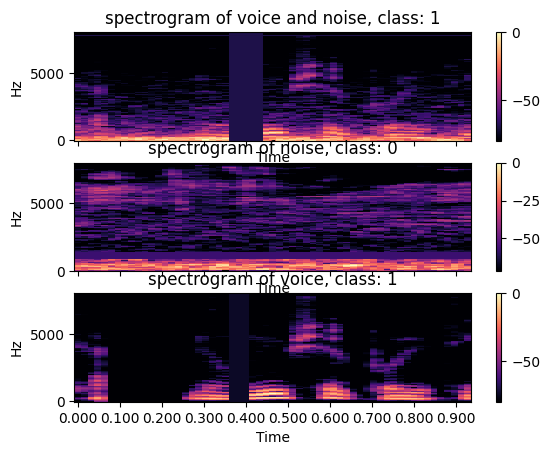

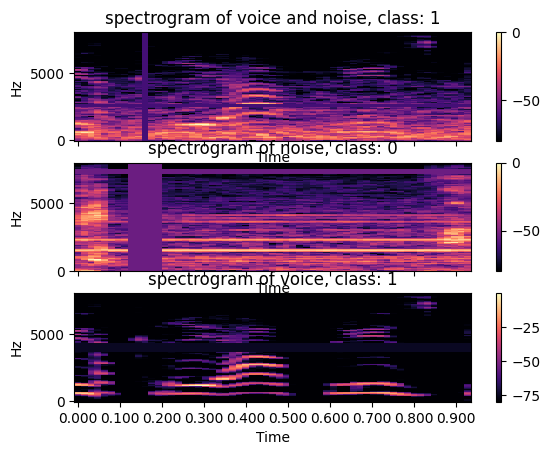

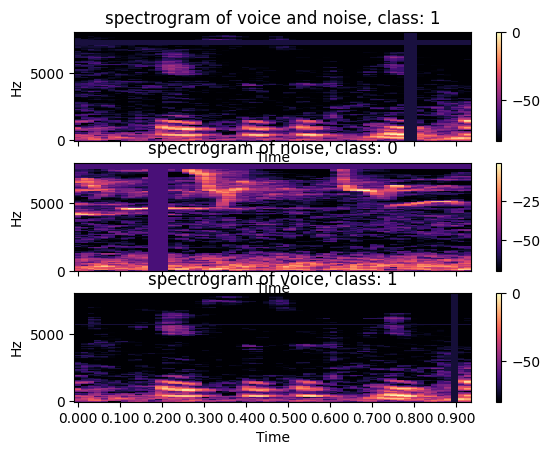

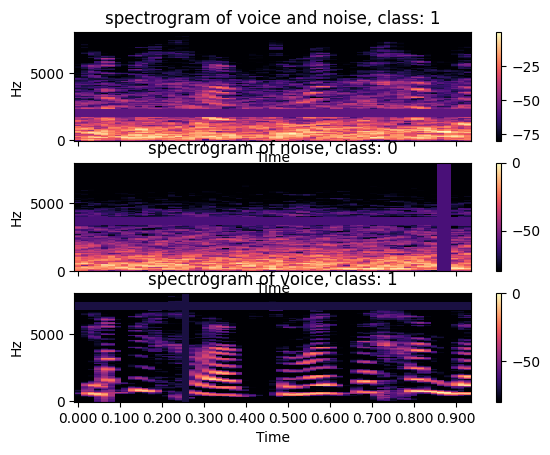

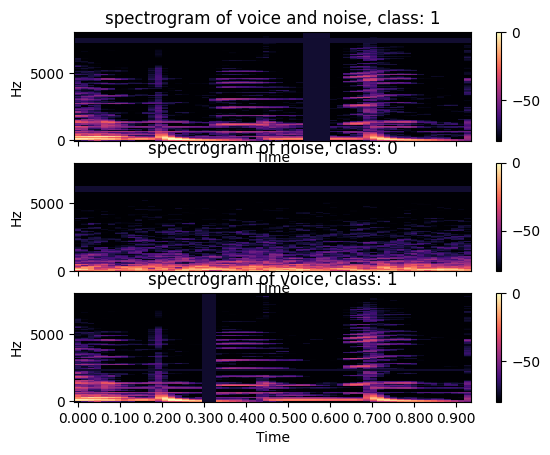

In [6]:
batch_size = 50
flag = 1  
train_gen = DataGenerator(df_train_voice=df_train_voice, df_val_voice=df_val_voice, df_train_noise=df_train_noise, df_train_noise_2=df_train_noise_2, df_val_noise=df_val_noise, df_val_noise_2=df_val_noise_2, data_path=data_path, batch_size=batch_size, flag=flag)
val_gen = train_gen.load_val()

 The neural network:

The neural network is built as follows: convolution layer with input size as the spectrogram size of 1 second. This layer includes 8 filters with kernel size (3,3) and a RELU activation function. MAXPOOLING layer. Convolution layer with 16 filters and RELU activation function. MAXPOOLING. Convolution layer with 32 filters RELU activation function. MAXPOOLING. Convolution layer with 64 filters, RELU function. Then FLATTEN, DENSE layer with 128 neurons and RELU activation function. 10% DROPOUT. DENSE layer with 64 neurons and RELU function. 10% DROPOUT, DENSE layer with 28 neurons and RELU function, 10% DROPOUT, DENSE layer with 2 neurons, and SOFTMAX activation function.
Learning rate of 0.001. Adam optimizer with categorical cross-entropy loss.

In [7]:
                            
def Model():
    
    model = Sequential()

    model.add(Conv2D(input_shape=(val_gen[0][0].shape[0], val_gen[0][0].shape[1], 1),filters=8,kernel_size=(3,3),padding="same", activation="relu"))
    
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=16,kernel_size=(3,3),padding="same", activation="relu"))
    
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
    
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))

    model.add(Flatten())

    model.add(Dense(units=128, activation="relu"))
    
    model.add(Dropout(0.1))
    
    model.add(Dense(units=64, activation="relu"))
    
    model.add(Dropout(0.1))
    
    model.add(Dense(units=28, activation="relu"))
    
    model.add(Dropout(0.1))
    
    model.add(Dense(units=2, activation="softmax"))
    
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
    model.summary()
    
    return model

model = Model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 59, 8)        80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 29, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 29, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 14, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 7, 32)        0

In the next cell, we actually activated the model with the Hyperparameters of batch_size=50, epochs = EarlyStopping  - as long as the val loss is decreased the machine is running with patience of 1, finally, we got 6 epochs.



In [8]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)

hist = model.fit(train_gen, validation_data=val_gen, validation_steps=len(val_gen[0]) // (batch_size*2),  steps_per_epoch=(len(df_train_noise)*2) //(batch_size*2), epochs=50, callbacks=[es])


Epoch 1/50
87/87 [==============================] - 1450s 17s/step - loss: 0.3083 - accuracy: 0.8726 - val_loss: 0.1748 - val_accuracy: 0.9362
Epoch 2/50
87/87 [==============================] - 1388s 16s/step - loss: 0.1592 - accuracy: 0.9420 - val_loss: 0.1370 - val_accuracy: 0.9486
Epoch 3/50
87/87 [==============================] - 1379s 16s/step - loss: 0.1396 - accuracy: 0.9492 - val_loss: 0.1346 - val_accuracy: 0.9482
Epoch 4/50
87/87 [==============================] - 1391s 16s/step - loss: 0.1223 - accuracy: 0.9560 - val_loss: 0.1152 - val_accuracy: 0.9593
Epoch 5/50
87/87 [==============================] - 1384s 16s/step - loss: 0.1165 - accuracy: 0.9593 - val_loss: 0.0960 - val_accuracy: 0.9665
Epoch 6/50
87/87 [==============================] - 1378s 16s/step - loss: 0.1062 - accuracy: 0.9614 - val_loss: 0.1006 - val_accuracy: 0.9657
Epoch 6: early stopping


The graphs of loss and accuracy are displayed below, as well as the confusion matrix of the validation set and the test set.

we can see that we got: val_loss: 0.09 and val_accuracy: 96.65%

The Confusion matrix of the val set:

[1219   35]

[ 51 1203]]



The Confusion_matrix of the test set:

[[615   13]

[ 31 597]]


 

79/79 [==============================] - 1s 10ms/step
the confusion_matrix of the val set: 
 [[1219   35]
 [  51 1203]]


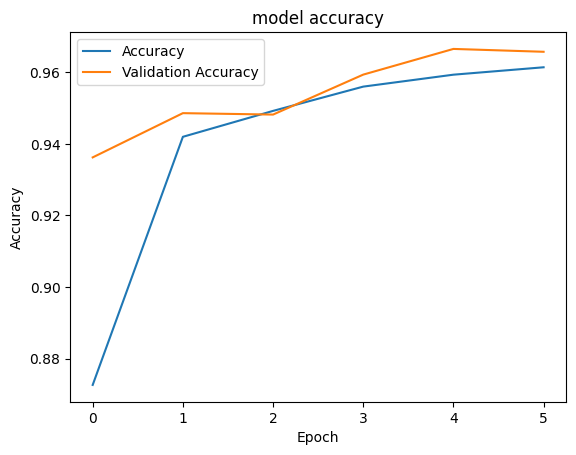

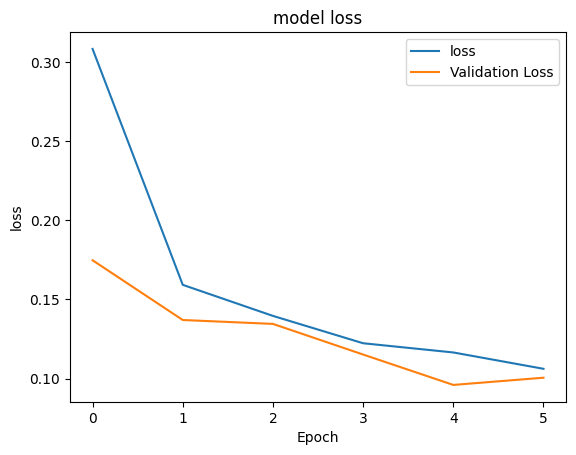

In [9]:
plt.figure()
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("model accuracy")
plt.legend(["Accuracy","Validation Accuracy"])

plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["loss", "Validation Loss"])

y_pred_1 = model.predict(val_gen[0])
y_pred_1 = y_pred_1.argmax(axis=1)
y_val = val_gen[1].argmax(axis=1)
print("the confusion_matrix of the val set: \n",  confusion_matrix(y_val,y_pred_1))


plt.show()



40/40 [==============================] - 0s 10ms/step
the confusion_matrix of the test set: 
 [[615  13]
 [ 31 597]]


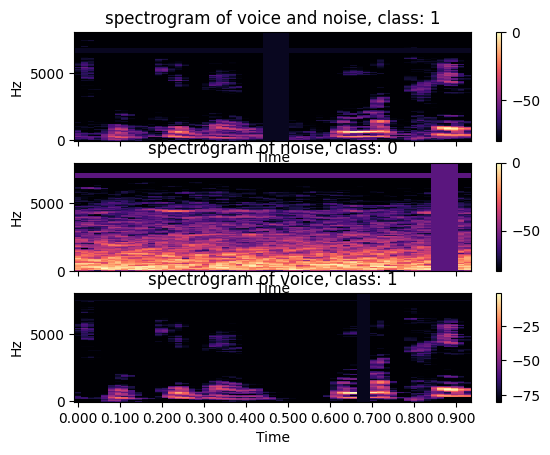

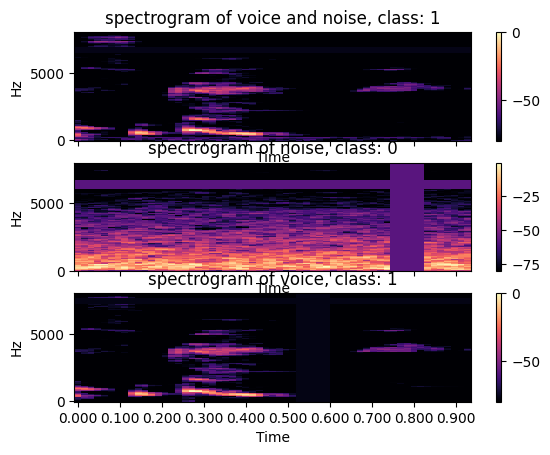

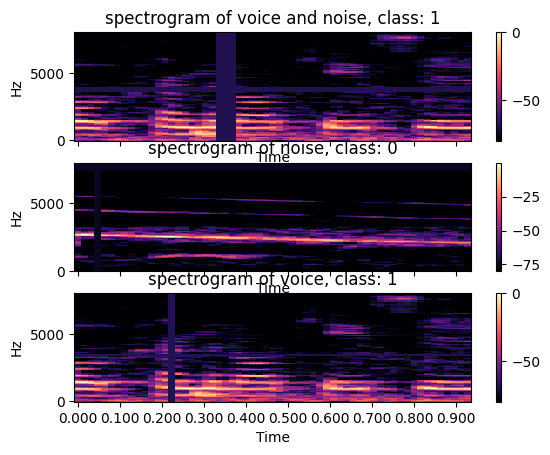

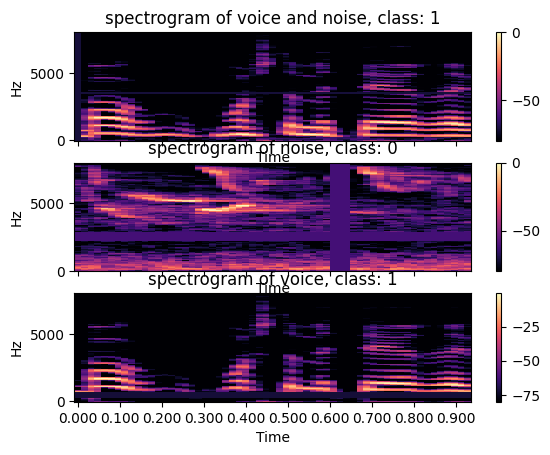

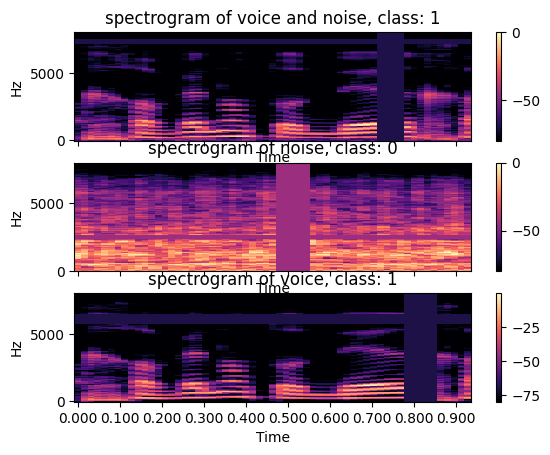

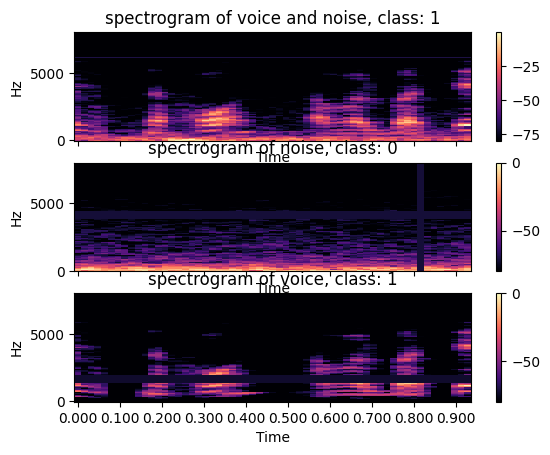

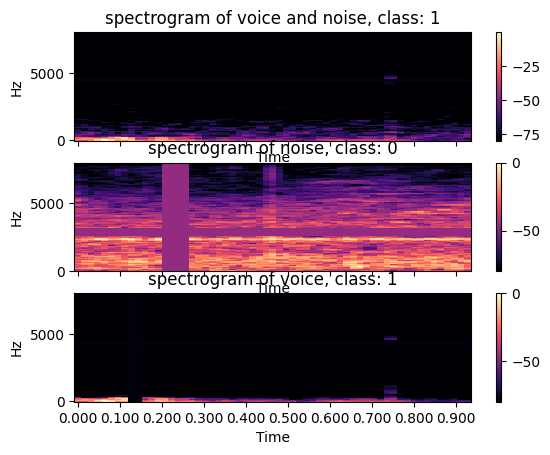

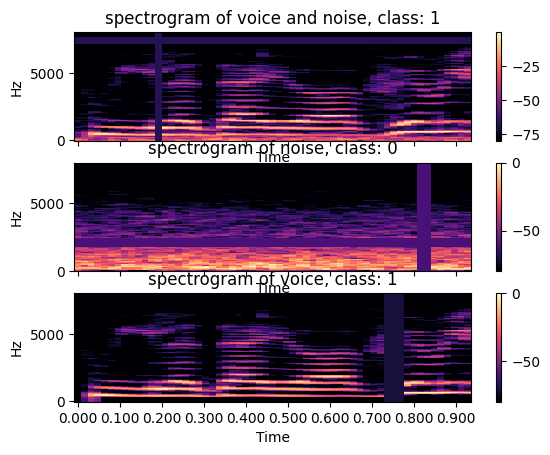

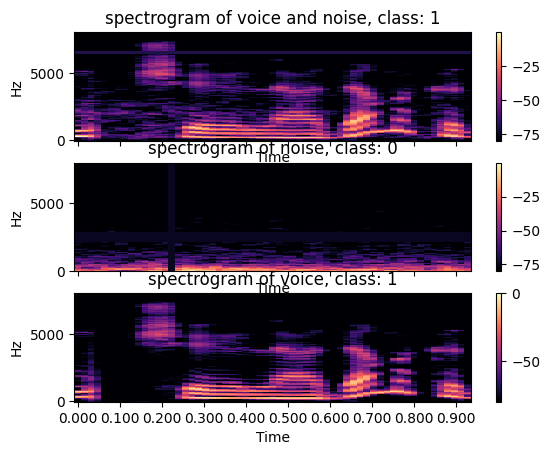

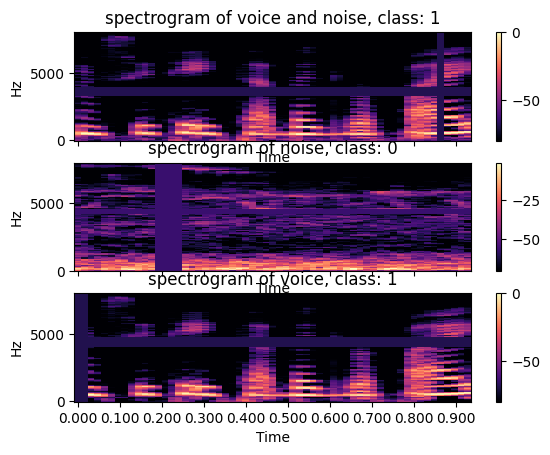

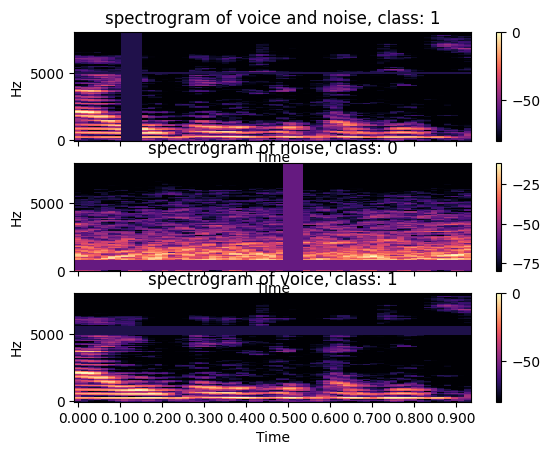

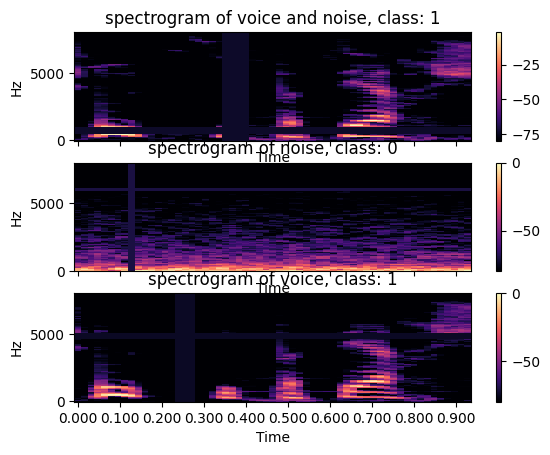

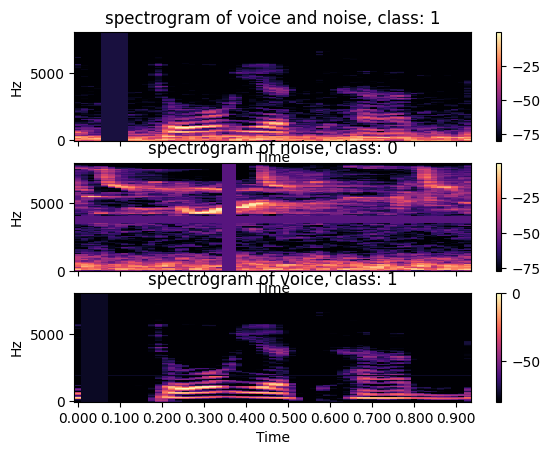

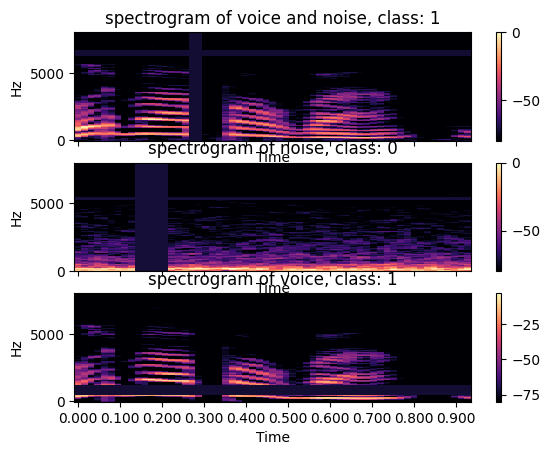

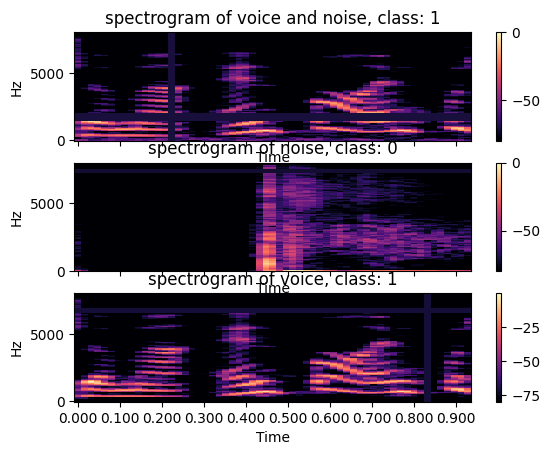

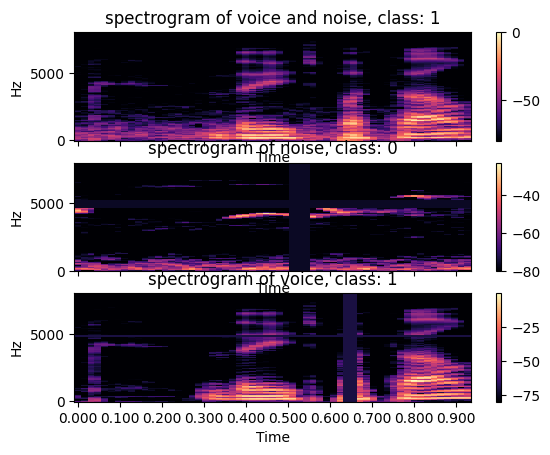

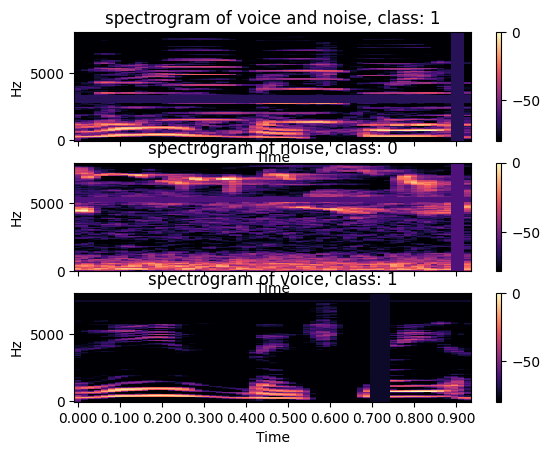

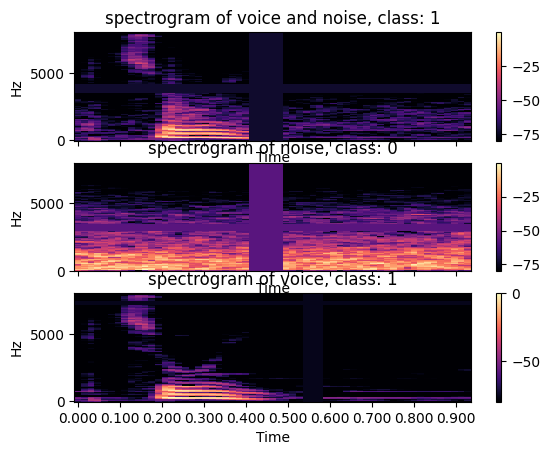

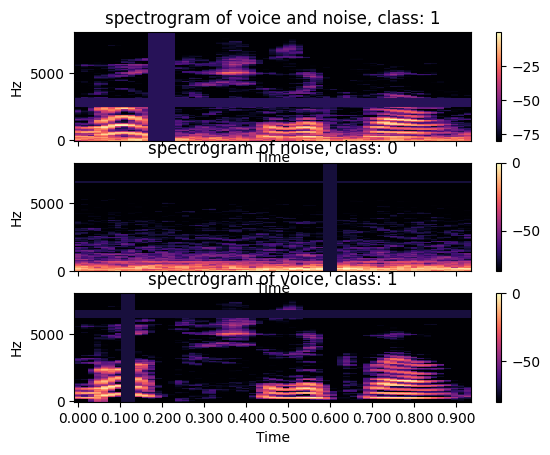

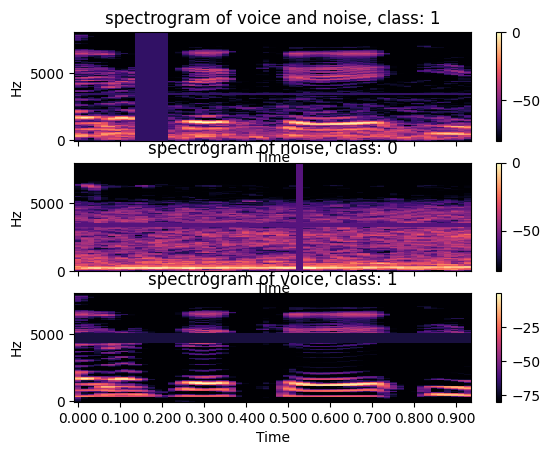

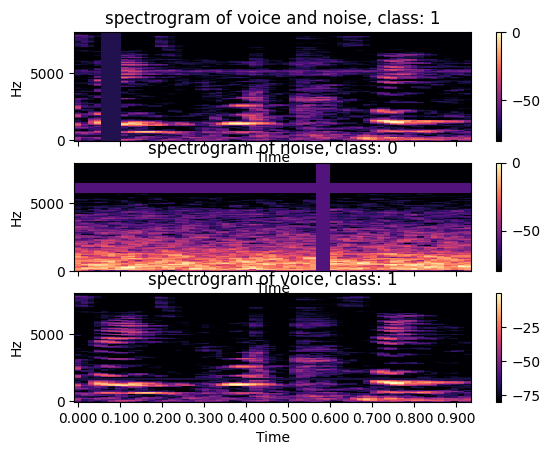

In [10]:
# ----------------------------
# to evaluate the test set we load only the test data to the DataGenerator class   
# ----------------------------

train_gen_for_test = DataGenerator(df_train_voice=None, df_val_voice=df_test_voice, df_train_noise=None, df_train_noise_2=None, df_val_noise=df_test_noise, df_val_noise_2=df_test_noise_2, data_path=data_path, batch_size=None, flag=1)
test_gen = train_gen_for_test.load_val()
y_pred = model.predict(test_gen[0])
y_pred = y_pred.argmax(axis=1)
y_test = test_gen[1].argmax(axis=1)
print("the confusion_matrix of the test set: \n", confusion_matrix(y_test,y_pred)) 

plt.show()


We save the model to reuse later

In [11]:
model.save(r'C:\Users\User\Downloads\few_spekers\final model 1 second mel-spectrograms')

INFO:tensorflow:Assets written to: C:\Users\User\Downloads\few_spekers\final model 1 second mel-spectrograms\assets


INFO:tensorflow:Assets written to: C:\Users\User\Downloads\few_spekers\final model 1 second mel-spectrograms\assets


In the next cells, we could load the model we saved, connect a microphone to the computer, and start recording.
every 1 second we will see on the screen the probability of getting a voice. high probability means the system detected the voice. we average those probabilities over 10 seconds - which means the system gives us the mean probability of getting a voice in the past 10 seconds. then we will get on the screen the mel-spectrograms of each second.
We arbitrarily decided that if the average probability of the past 10 seconds is above 0.8 we print 'speak', otherwise 'noise'.


In [1]:
import tensorflow as tf
model = tf.keras.models.load_model(r'C:\Users\User\Downloads\few_spekers\final model 1 sec mel-spectrograms')

In [12]:
import pyaudio
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import time
from tkinter import TclError
import sklearn
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore') 

start recording
1/1 [==============================] - 0s 17ms/step
processing time:  10.100602149963379
0.011289744
noise
1/1 [==============================] - 0s 17ms/step
done recording


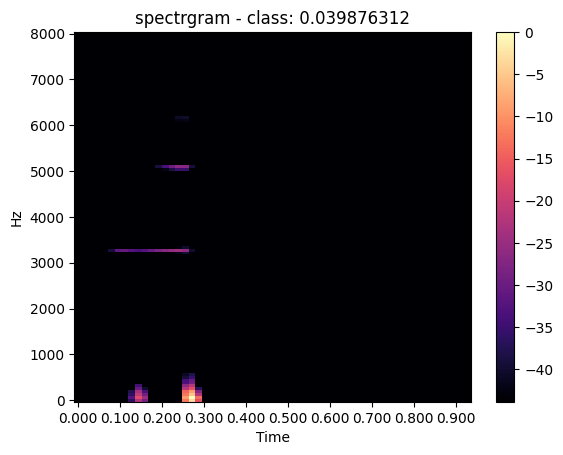

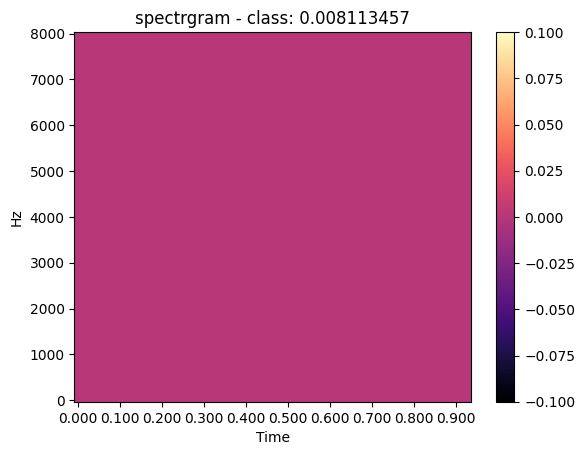

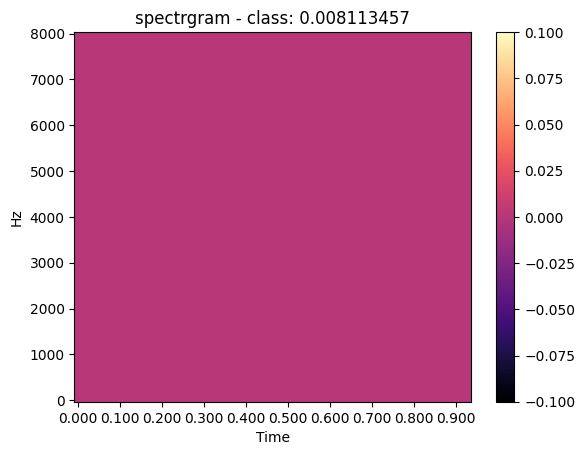

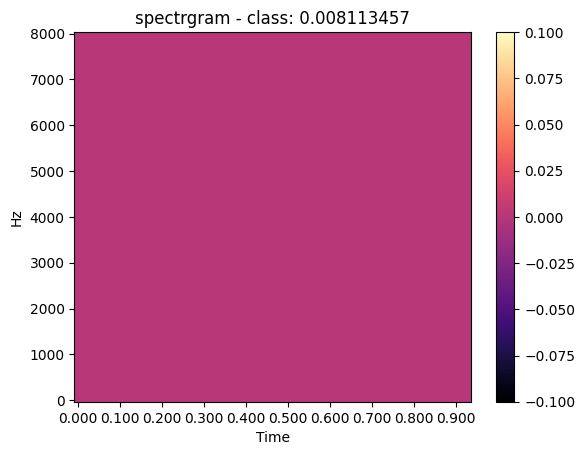

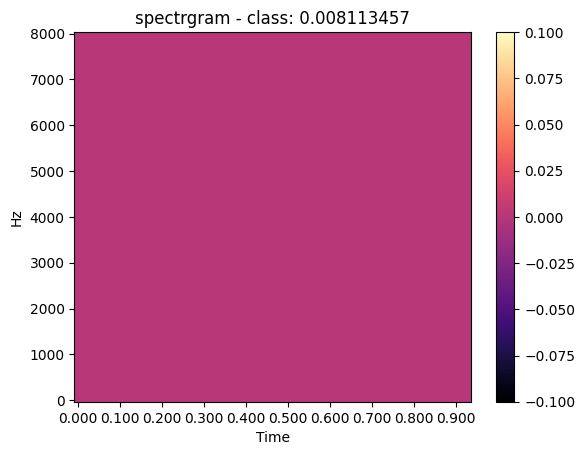

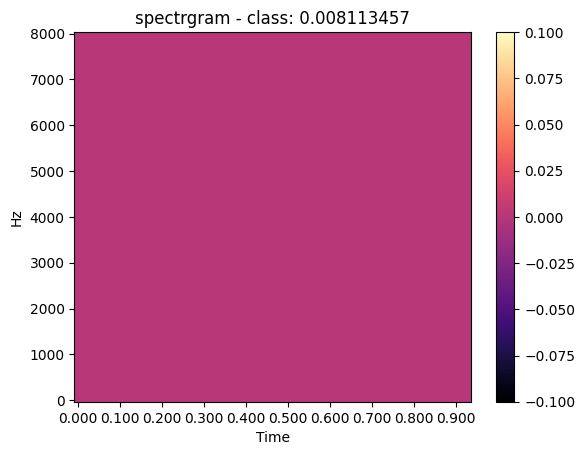

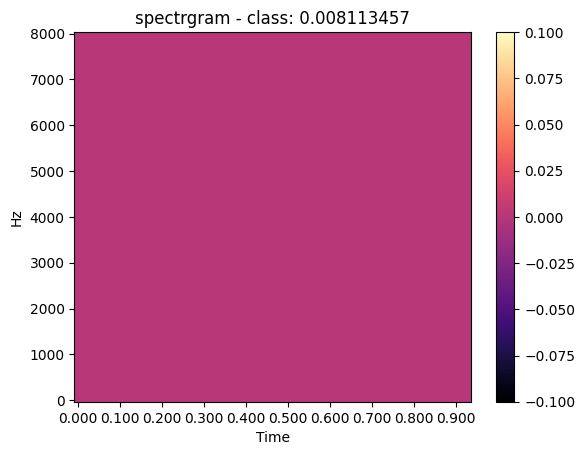

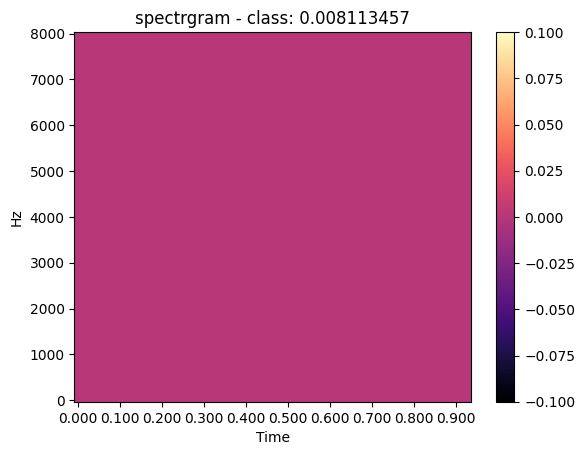

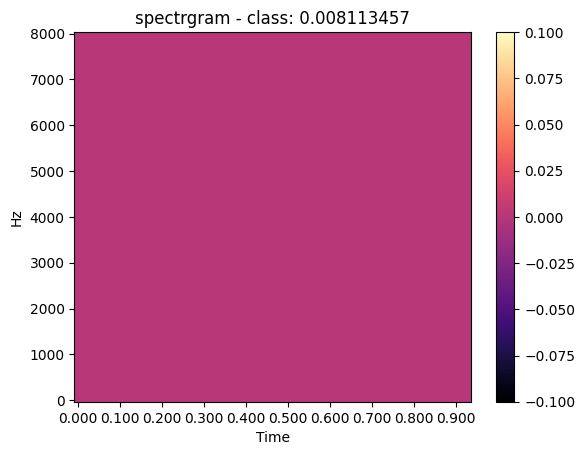

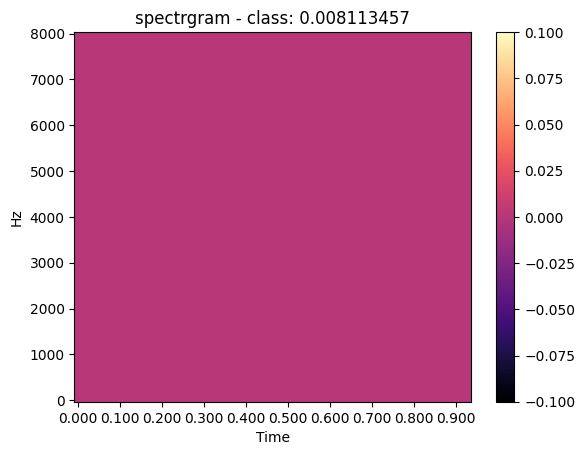

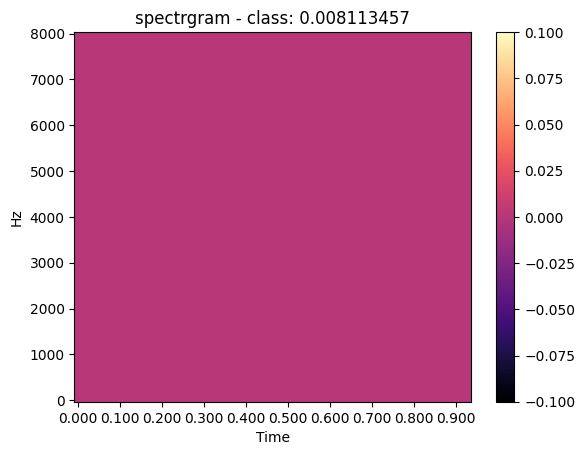

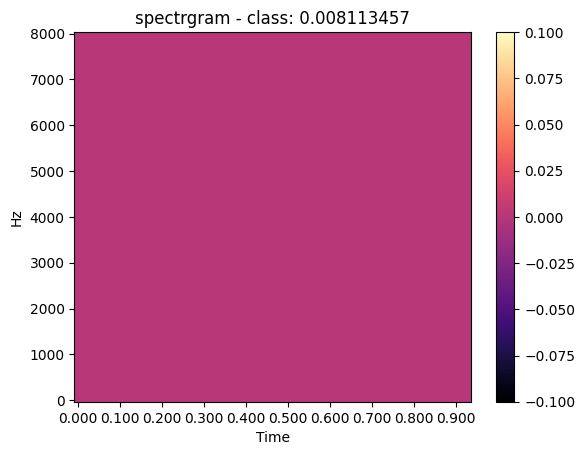

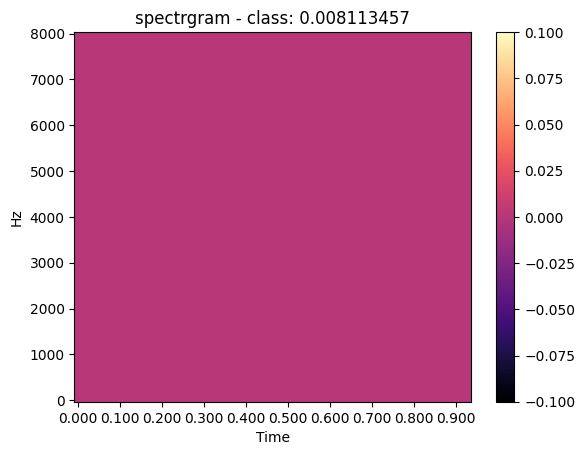

In [13]:
# ----------------------------
### Real time predict
# ----------------------------
duration = 1 
FORMAT = pyaudio.paFloat32
CHANNELS = 1
RATE = 16000
CHUNK = RATE * duration
len_buffer = 9
p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,channels=CHANNELS,rate=RATE,input=True,frames_per_buffer=CHUNK)
print("start recording")
list_of_buffer = []
try:
    while True:
        
        i = 0
        start = time.time()
        BUFFER = []
        
        while i <= len_buffer:
                            
            data = stream.read(CHUNK)
            decoded = np.fromstring(data, 'f')
            spectrogram = librosa.feature.melspectrogram(decoded, sr=16000, n_fft=1024, hop_length=256, center=False) #creating mel-spectrogram
            spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max) # Convert to decibels
            scaler = MinMaxScaler() # scaling between 0 to 1
            normalized_spec = scaler.fit_transform(spectrogram_db) #normalize bewteen 0 to 1
            S = normalized_spec.reshape(1, normalized_spec.shape[0], normalized_spec.shape[1], 1) # reshape to the CNN model shape
            predict = model.predict(S) # making prediction
            BUFFER.append(predict[0][1])
            i+=1
            fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True) 
            img = librosa.display.specshow(spectrogram_db, sr=16000, x_axis='time', y_axis='linear', ax=ax ,hop_length=256) # display the spectrogram after recording end 
            ax.set(title='spectrgram - class: ' + str(predict[0][1]))
            plt.colorbar(img, ax=ax)
        nmean_buffer = np.mean(BUFFER)
        end = time.time()
        print('processing time: ', end-start)
        print(nmean_buffer)
        if nmean_buffer > 0.8: # dection bundray of 0.8
            print("speak")
        else:
            print("noise")
except KeyboardInterrupt:
    print("done recording")
stream.stop_stream()
stream.close()
p.terminate()

references

K. Doshi, “Audio Deep Learning Made Simple (Part 1): State-of-the-Art Techniques.” [Online]. Available: https://towardsdatascience.com/audio-deep-learning-made-simple-part-1-state-of-the-art-techniques-da1d3dff2504.

K. Doshi, “Audio Deep Learning Made Simple (Part 2): Why Mel Spectrograms perform better.” [Online]. Available: https://towardsdatascience.com/audio-deep-learning-made-simple-part-2-why-mel-spectrograms-perform-better-aad889a93505.

K. Doshi, “Audio Deep Learning Made Simple (Part 3): Data Preparation and Augmentation.” [Online]. Available: https://towardsdatascience.com/audio-deep-learning-made-simple-part-3-data-preparation-and-augmentation-24c6e1f6b52.

K. Doshi, “Audio Deep Learning Made Simple: Automatic Speech Recognition (ASR), How it Works.” [Online]. Available: https://towardsdatascience.com/audio-deep-learning-made-simple-automatic-speech-recognition-asr-how-it-works-716cfce4c706.

Ketan Doshi, “Audio Deep Learning Made Simple: Sound Classification, Step-by-Step.” [Online]. Available: https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5.



